In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from sklearn import model_selection

In [2]:
# load dataset from from sklearn
from sklearn.datasets import load_digits
digits = load_digits()
print(digits.keys())
print(type(digits.data))
print(type(digits.images))
print(digits.images.shape)

dict_keys(['data', 'target', 'target_names', 'images', 'DESCR'])
<class 'numpy.ndarray'>
<class 'numpy.ndarray'>
(1797, 8, 8)


# 3. Data Preparation

In [3]:
def select_by_y(X, Y, selection):
    """
    select instances whose y is in selection
    Args:
        X: feature set
        Y: response(target) set
        selection: list of target value
    """
    N = len(X)
    new_X = []
    new_Y = []
    for i in range(N):
        if Y[i] in selection:
            new_X.append(X[i])
            new_Y.append(Y[i])
    return np.asarray(new_X),np.asarray(new_Y)

# select instances whose target are "1" and "7"
X_all, Y_all = select_by_y(digits.data, digits.target, [1, 7])
print("the numebr of instances is", len(X_all))

# split data set into training data and test data
X_train, X_test, Y_train, Y_test = model_selection.train_test_split(X_all, Y_all, test_size=0.4, random_state=0)
print("number of instances in traning data:", len(X_train))
print("number of instances in test data:", len(X_test))

the numebr of instances is 361
number of instances in traning data: 216
number of instances in test data: 145


## 3.1 Dimension Reduction
* choose two pixels that seem to have a big influence
* come up with some clever combination of the 64 original pixel values into 2 features

In [4]:
X_train_1, _ = select_by_y(X_train, Y_train, [1])
X_train_7, _ = select_by_y(X_train, Y_train, [7])

# calculate the mean of all instances of 1 and 7 respectively
mean_1 = np.mean(X_train_1, axis=0)
mean_7 = np.mean(X_train_7, axis=0)

# mean_1_image = mean_1.reshape((8,8))
# mean_7_image = mean_7.reshape((8,8))
# def show_image(image):
#     plt.figure()
#     plt.gray()
#     plt.imshow(image, interpolation="nearest")
#     plt.show()
# show_image(mean_1_image)
# show_image(mean_7_image)

# select the most influential K dimensions
def topK_important_dimension(mean_a, mean_b, K):
    N = len(mean_a)
    assert K<=N
    return np.argsort(np.absolute(np.subtract(mean_a, mean_b)))[N-K:]

dims = topK_important_dimension(mean_1, mean_7, 2)

def reduce_dim(X):
    N = len(X)
    return X[:,dims] # take the most 2 important dimensions

X_train = reduce_dim(X_train)
X_test = reduce_dim(X_test)
X_train_1 = reduce_dim(X_train_1)
X_train_7 = reduce_dim(X_train_7)
#print(X_train)


## 3.2 Scatterplot

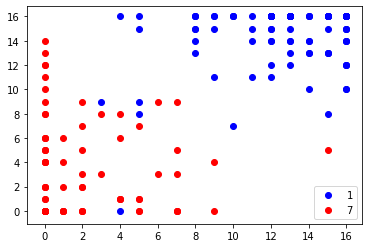

In [5]:
plt.scatter(X_train_1[:,0].transpose(), X_train_1[:,1].transpose(), c='b', label="1")
plt.scatter(X_train_7[:,0].transpose(), X_train_7[:,1].transpose(), c='r', label="7")
plt.legend()
plt.show()

# 4. Nearest Mean

## 4.1 Implement the nearest mean classifier

In [6]:
def dist_vec(training, test):
    """
    calculate the distance matrix using vectorization method
    """
    training_square = np.sum(training*training, axis=1, keepdims=True)
    test_square = np.sum(test*test, axis=1, keepdims=True).T
    distances = np.dot(training, test.T)
    distances *= -2
    distances += training_square
    distances += test_square
    np.maximum(distances, 0, distances)
    np.sqrt(distances, distances)
    return distances

def nearest_mean(training_features, training_labels, test_features):
    """
    predict by nearest mean
    """
    train_1, _ = select_by_y(training_features, training_labels, [1]) # training features whose label is 1
    train_7, _ = select_by_y(training_features, training_labels, [7]) # training features whose label is 7
    mean_1 = np.mean(train_1, axis=0)
    mean_7 = np.mean(train_7, axis=0)
    mean_matrix = np.vstack((mean_1, mean_7))
    distance_matrix = dist_vec(mean_matrix, test_features) # distance matrix: 2*M (M is the number of instances in test set)
    sorted_distance_indices = np.argsort(distance_matrix, axis=0)
    nearest_indices = sorted_distance_indices[0,:]
    return np.asarray([1,7]).take(nearest_indices)

def cal_err(Y_test, Y_pred):
    """calculate the error rate"""
    return np.sum(np.subtract(Y_test, Y_pred)!=0)/Y_pred.size
    
Y_pred = nearest_mean(X_train, Y_train, X_test)
print(cal_err(Y_test, Y_pred))
    
# a = np.asarray([1,7])
# print(a.take([0,1,1,1,1]))

0.006896551724137931


## 4.2 Visualize the decision regions

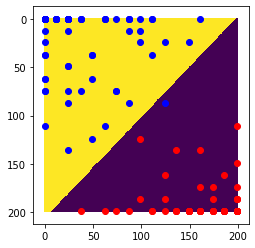

In [7]:
mean_1 = np.mean(X_train_1, axis=0)
mean_7 = np.mean(X_train_7, axis=0)
def predict(X):
    distance_1 = np.sqrt(np.sum(np.subtract(X, mean_1)**2))
    distance_7 = np.sqrt(np.sum(np.subtract(X, mean_7)**2))
    if distance_1 < distance_7:
        return 1
    else:
        return 7

color_1 = 0.2
color_2 = 0.3

def decision_region():
    image = np.zeros((200, 200))
    step = 16 / (200-1)
    for i in range(200):
        for j in range(200):
            x0 = i*step
            x1 = j*step
            if predict([x0,x1]) == 1:
                image[i][j] = color_1
            else :
                image[i][j] = color_2
    return image


X_test_1, _ = select_by_y((X_test*199/16).astype(int), Y_test, [1])
X_test_7, _ = select_by_y((X_test*199/16).astype(int), Y_test, [7])

plt.figure()
plt.imshow(decision_region())
plt.scatter(X_test_1[:,0].transpose(), X_test_1[:,1].transpose(), c="r")
plt.scatter(X_test_7[:,0].transpose(), X_test_7[:,1].transpose(), c="b")
plt.show()
            
    